## An example of model inference and visualization
#### Prepare the input data and model

We generate the cropped images from COCO2017 valiadation set by using the GT human bounding boxes. And we load the model with the COCO pre-trained weights. The models also can be directly loaded from torch hub ([CoLab demo](https://colab.research.google.com/drive/1v2LY_rAZXqexPjiePmqgma4aw-qmRek6?usp=sharing)).

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path as osp
import sys
import os
import torch

from visualize import update_config, add_path

lib_path = osp.join('lib')
add_path(lib_path)

import dataset as dataset
from config import cfg
import models
import os
import torchvision.transforms as T
from utils.utils import collate_fn

os.environ['CUDA_VISIBLE_DEVICES'] ='0'
file_name = 'experiments/coco/transpose_r/TP_R_256x192_d256_h1024_enc4_mh8.yaml' # choose a yaml file
f = open(file_name, 'r')
update_config(cfg, file_name)

model_name = 'T-R-A4'
assert model_name in ['T-R', 'T-H','T-H-L','T-R-A4', 'T-H-A6', 'T-H-A5', 'T-H-A4' ,'T-R-A4-DirectAttention']

normalize = T.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )

toTensor_normalinze = T.Compose([
                            T.ToTensor(),
                            normalize,
                        ])

val_dataset = eval('dataset.'+cfg.DATASET.DATASET)(
        cfg, cfg.DATASET.ROOT, cfg.DATASET.TEST_SET, False,
        toTensor_normalinze
    )

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=cfg.TEST.BATCH_SIZE_PER_GPU*len(cfg.GPUS),
    shuffle=False,
    num_workers=cfg.WORKERS,
    pin_memory=True,
    collate_fn=collate_fn
)


device = torch.device('cuda')
model = eval('models.'+cfg.MODEL.NAME+'.get_pose_net')(
    cfg, is_train=True
)

if cfg.TEST.MODEL_FILE:
    print('=> loading model from {}'.format(cfg.TEST.MODEL_FILE))
    model.load_state_dict(torch.load(cfg.TEST.MODEL_FILE), strict=True)
else:
    raise ValueError("please choose one ckpt in cfg.TEST.MODEL_FILE")

model.to(device)
print("model params:{:.3f}M".format(sum([p.numel() for p in model.parameters()])/1000**2))

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
:: conv1.weight is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: bn1.running_mean is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: bn1.running_var is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: bn1.weight is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: bn1.bias is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.conv1.weight is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.bn1.running_mean is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.bn1.running_var is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.bn1.weight is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.bn1.bias is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.conv2.weight is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.bn

#### Obtain the predictions

We feed an input sample to the model, get the predicted keypoint heatmaps and further obtain the positions of keypoints. 

In [ ]:
import numpy as np 
from core.inference import get_final_preds
from utils import transforms, vis
import cv2
from utils.utils import get_valid_output
from utils.transforms import flip_back
from visualize import *

model.eval()

with torch.no_grad():
    for i, (length, input, pos_mask, target, target_weight, meta) in enumerate(val_loader):
        if i != 1:
            continue
        input = input.cuda()
        pos_mask = pos_mask.cuda()
        outputs = model(input, pos_mask, length)
        if isinstance(outputs, list):
            output = outputs[-1]
        else:
            output = outputs

        output = get_valid_output(output, length)

        if cfg.TEST.FLIP_TEST:
                # this part is ugly, because pytorch has not supported negative index
                # input_flipped = model(input[:, :, :, ::-1])
                input_flipped = np.flip(input.cpu().numpy(), 3).copy()
                pos_mask_flipped = np.flip(pos_mask.cpu().numpy(), 3).copy()

                input_flipped = torch.from_numpy(input_flipped).cuda()
                pos_mask_flipped = torch.from_numpy(pos_mask_flipped).cuda()

                outputs_flipped = model(input_flipped.cuda(), pos_mask_flipped.cuda(), length)

                if isinstance(outputs_flipped, list):
                    output_flipped = outputs_flipped[-1]
                else:
                    output_flipped = outputs_flipped

                output_flipped = get_valid_output(output_flipped, length)
                
                output_flipped = flip_back(output_flipped.cpu().numpy(),
                                           val_dataset.flip_pairs)
                output_flipped = torch.from_numpy(output_flipped.copy()).cuda()

                output = (output + output_flipped) * 0.5
        
        c = meta['center'].numpy()
        s = meta['scale'].numpy()
        preds, maxvals = get_final_preds(
                cfg, output.clone().cpu().numpy(), c, s, transform_back=False)
        ori_preds = preds.copy()
        # 只取一条数据看attention map
        output_res = output.split(1, dim=0)
        imgs = input.split(1, dim=0)
        pos_mask_one = pos_mask.split(1, dim=0)
        preds = torch.from_numpy(preds)
        preds = preds.split(1, dim=0)

        index = 0
        img = imgs[index].cpu().clone()
        pos_mask_one = pos_mask_one[index].clone()
        preds = preds[index].numpy()
        output = output[index]

        ori_img_patch = meta['image'][index]
        ori_img = cv2.imread(ori_img_patch, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
        ori_img = toTensor_normalinze(ori_img)
        # inspect_all_atten_map_by_locations(ori_img, input, pos_mask, length, model, ori_preds, model_name="transposer", mode='dependency', save_img=True, threshold=0.0)
        break  


# from heatmap_coord to original_image_coord
query_locations = np.array([p*4+0.5 for p in preds[0]])

# print(query_locations)
inspect_atten_map_by_locations(img, pos_mask_one, model, query_locations, model_name="transposer", mode='dependency', save_img=True, threshold=0.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


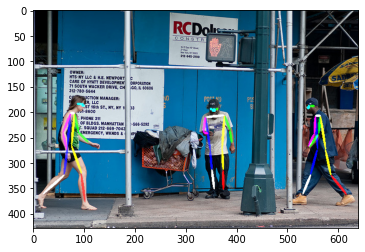

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 16 is out of bounds for dimension 2 with size 16

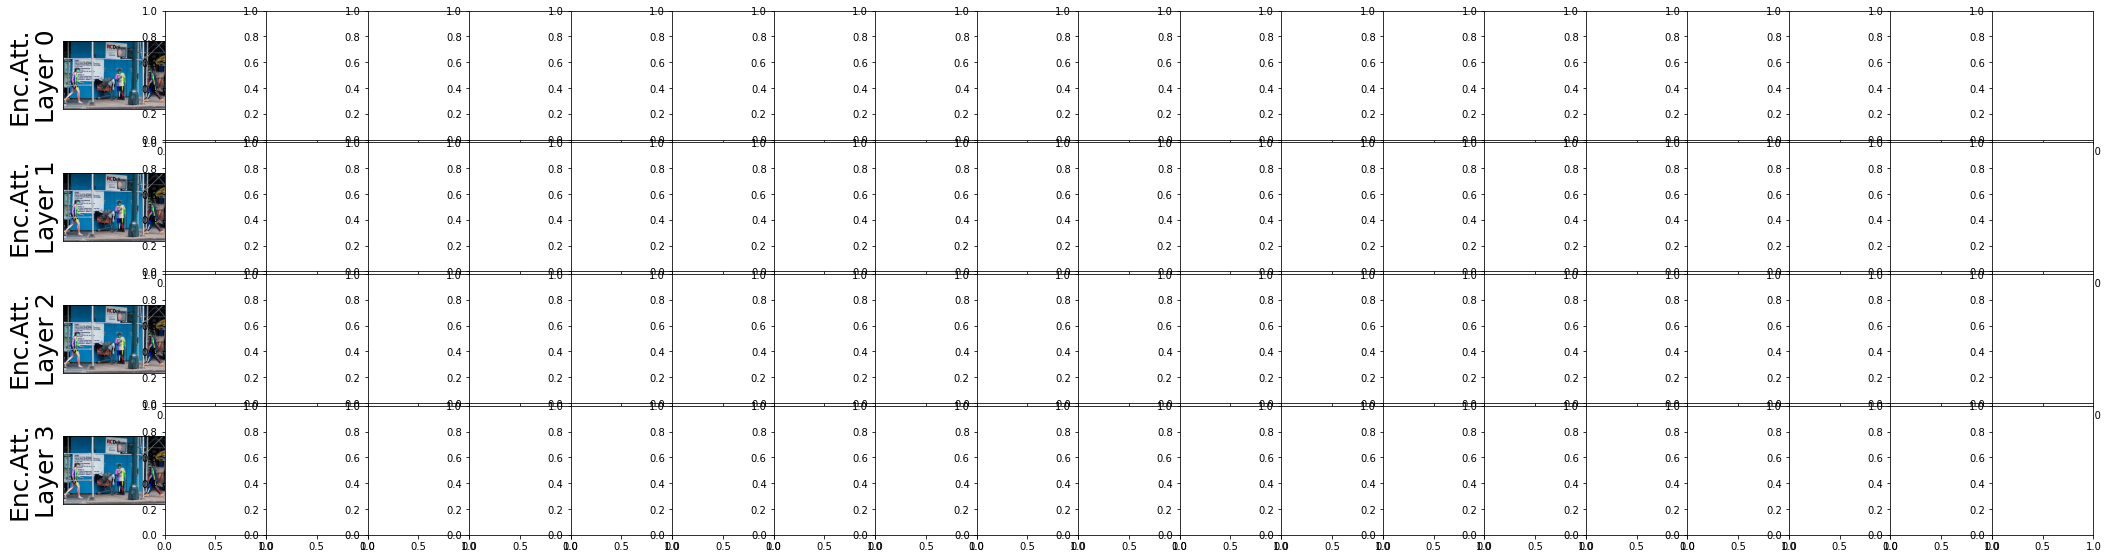

In [2]:
import numpy as np 
from core.inference import get_final_preds
from utils import transforms, vis
import cv2
from utils.utils import get_valid_output
from utils.transforms import flip_back
from visualize import *

model.eval()

with torch.no_grad():
    for i, (length, input, pos_mask, target, target_weight, meta) in enumerate(val_loader):
        if i != 1:
            continue
        input = input.cuda()
        pos_mask = pos_mask.cuda()
        outputs = model(input, pos_mask, length)
        if isinstance(outputs, list):
            output = outputs[-1]
        else:
            output = outputs

        output = get_valid_output(output, length)

        if cfg.TEST.FLIP_TEST:
                # this part is ugly, because pytorch has not supported negative index
                # input_flipped = model(input[:, :, :, ::-1])
                input_flipped = np.flip(input.cpu().numpy(), 3).copy()
                pos_mask_flipped = np.flip(pos_mask.cpu().numpy(), 3).copy()

                input_flipped = torch.from_numpy(input_flipped).cuda()
                pos_mask_flipped = torch.from_numpy(pos_mask_flipped).cuda()

                outputs_flipped = model(input_flipped.cuda(), pos_mask_flipped.cuda(), length)

                if isinstance(outputs_flipped, list):
                    output_flipped = outputs_flipped[-1]
                else:
                    output_flipped = outputs_flipped

                output_flipped = get_valid_output(output_flipped, length)
                
                output_flipped = flip_back(output_flipped.cpu().numpy(),
                                           val_dataset.flip_pairs)
                output_flipped = torch.from_numpy(output_flipped.copy()).cuda()

                output = (output + output_flipped) * 0.5
        
        c = meta['center'].numpy()
        s = meta['scale'].numpy()
        preds, maxvals = get_final_preds(
                cfg, output.clone().cpu().numpy(), c, s, transform_back=True)
        ori_preds = preds.copy()
        # 只取一条数据看attention map
        output_res = output.split(1, dim=0)
        imgs = input.split(1, dim=0)
        pos_mask_one = pos_mask.split(1, dim=0)
        preds = torch.from_numpy(preds)
        preds = preds.split(1, dim=0)

        index = 0
        img = imgs[index].cpu().clone()
        pos_mask_one = pos_mask_one[index].clone()
        preds = preds[index].numpy()
        output = output[index]

        ori_img_patch = meta['image'][index]
        ori_img = cv2.imread(ori_img_patch, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
        ori_img = toTensor_normalinze(ori_img)
        inspect_all_atten_map_by_locations(ori_img, input, pos_mask, length, model, ori_preds, model_name="transposer", mode='dependency', save_img=True, threshold=0.0)
        break  


# from heatmap_coord to original_image_coord
# query_locations = np.array([p*4+0.5 for p in preds[0]])

# print(query_locations)
# inspect_atten_map_by_locations(img, pos_mask_one, model, query_locations, model_name="transposer", mode='dependency', save_img=True, threshold=0.0)

#### Obtain the attention maps and visualize them
The attention maps can be returned by the forward function of the model, or can be hooked by the hook function of pytorch. Here we conduct the hook implementation in the function `inspect_atten_map_by_locations`. 

In [ ]:
from visualize import inspect_atten_map_by_locations

inspect_atten_map_by_locations(img, pos_mask_one, model, query_locations, model_name="transposer", mode='dependency', save_img=True, threshold=0.0)

In [ ]:
from visualize import *

inspect_all_atten_map_by_locations(ori_img, pos_mask, model, preds, model_name="transposer", mode='dependency', save_img=True, threshold=0.0)